<a href="https://colab.research.google.com/github/UofA-AdamHamilton/Elo-Simulations/blob/main/EloPaperSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulations for Elo research paper
## Start time 11:52 am Tuesday 19th November 2024,
## By Dr Adam Hamilton

Goal: The purpose of this notebook is to generate the figures used in the paper The Impact of Intransitivity on the Elo Rating System by Dr Adam Hamilton, Dr Anna Kalenkova, and Professor Matthew Roughan, which is currently under review by the journal PLOS one (https://journals.plos.org/plosone/).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import expit, logit
from google.colab import files

# seeds the PRNG
np.random.seed(1)

def payoff_matrix(prob_array, pure_strategy_payoff):
  """
  function to create an expected payoff matrix
  Inputs
  prob_array: numpy array
    columns represent players, rows represent strategies.
    columns of the prob_array represent the pmfs of each player.
    All columns must contain non-negative real numbers and sum to one
  pure_strategy_payoff
    pure_strategy_payoff must be a skew-symmetric numpy array

  Outputs:
  matrix: numpy array
    An array that gives the probabilities of one player beating another,
    The rows and columns of the matrix represent players.
    matrix[i][j] = prob(player i beats player j)
  """
  m = len(prob_array[0]) #number of players
  matrix = np.zeros((m,m))
  for i in range(m):
    for j in range(m):
      matrix[i][j] = logit(prob_array[:,i].T @ pure_strategy_payoff @ prob_array[:,j])
  return matrix

def grad(vector):
  """
  Combinatorial gradient operator from Combinatorial Hodge theory
  """
  m = len(vector)
  matrix = np.zeros((m,m))
  for i in range(m):
    for j in range(m):
      matrix[i,j] = vector[i] - vector[j]
  return matrix

def div(matrix):
  """
  Combinatorial divergence operator from Combinatorial Hodge theory
  """
  h, w = np.shape(matrix)
  if h != w:
    raise Exception('the input matrix must be square')
  return (1/h)*matrix@np.ones((h,1))

def intransitivity_measure(skew_symmetric_matrix):
  """
  Implements the intransitivity measure of a skew symetric matrix from the
  paper
  """
  S = skew_symmetric_matrix
  STACM_S = grad(div(S))
  numerator = S - STACM_S
  return (1+np.linalg.norm(numerator))/(1 + np.linalg.norm(STACM_S))

def shannon_entropy(pmf):
  """
  Calculates the shannon entropy of a pmf whose support is a finite subset of
  the natural numbers
  Inputs:
    pmf a list or vector of non-negative, real numbers that sum to one.
  """
  H = 0
  pmf = np.array(pmf) # just in case we give t
  H = np.dot(np.log(pmf), pmf)
  return H

In [ ]:
# each column of each array is a PMF over rock, paper, and scissors
pmf_list_transitive = [np.array([[0.5, 0.5, 0.5],[0,0,0],[0.5, 0.5, 0.5]]),
                       np.array([[0.75, 0.5, 0.25],[0,0,0],[0.25, 0.5, 0.75]]),
                       np.array([[0.90, 0.5, 0.1],[0,0,0],[0.1, 0.5, 0.9]])]

# payoff for the the game.
# the order of the rows and columns is rock, paper and scissors
payoff_rps = np.array([[0.5, 0, 1],[1, 0.5, 0],[0, 1, 0.5]])

ground_truth_measurements_transitive = []
for pmf in pmf_list_transitive:
  ground_truth_measurements_transitive.append(intransitivity_measure(payoff_matrix(pmf, payoff_rps)))

# each column of each array is a pmf over rock, paper, and scissors
# stratgey selection matrix if players play according to Nash equilibrium
nash_matrix  = np.array([[1/3, 1/3, 1/3],[1/3, 1/3, 1/3],[1/3, 1/3, 1/3]])
# stratergy selection matrix where players just play one strategy
pure_strategy_matrix = np.array([[1,0,0],[0,1,0],[0,0,1]])
# Matrices ionterpolated between Nash equilibrium and pure strategy
pmf_list_intransitive = [nash_matrix,
                       0.5*nash_matrix + 0.5*pure_strategy_matrix,
                       0.1*nash_matrix + 0.9*pure_strategy_matrix ]

ground_truth_measurements_intransitive = []
for pmf in pmf_list_intransitive:
  ground_truth_measurements_intransitive.append(intransitivity_measure(payoff_matrix(pmf, payoff_rps)))

# now  for the empirical bit. let's deal with the two cases with the highest
# rate of wins and losses. These have the least entropy.

def trials(N, player_1_pmf, player_2_pmf):
  """
  returns a vector whose 1 entries are the victories of player 1 over player 2
  Inputs:
    N: A natural number of the number of trials
    player_1_pmf: A numpy array whose entries are probabilities of player 1
      throwing rock paper or scissors
    player_2_pmf: A numpy array whose entries are probabilities of player 2
      throwing rock paper or scissors
  """
  elements = [1,2,3]
  P1_throws = np.random.choice(elements, N, p=player_1_pmf)
  P2_throws = np.random.choice(elements, N, p=player_2_pmf)
  victories = []
  for i in range(N):
    if P1_throws[i] == P2_throws[i]:
      # a draw broken with a coin toss
      victories.append(np.random.randint(2))
    elif (P1_throws[i]- P2_throws[i])%3 == 1:
      # 1n this case plsyer 1 beats player 2
      victories.append(1)
    else:
      victories.append(0)
  return np.array(victories)

def estimate_from_victories(victories_array, n, confidence = 1):
  """
  Empirically estimates the advantage matrix from victories
  """
  p = np.sum(victories_array[0:n])/n

  estimate = logit(p)
  p_lower = max([(p - confidence*np.sqrt(n*(p)*(1-p))/n), 1.670142184809518e-05])
  p_upper = min([(p + confidence*np.sqrt(n*(p)*(1-p))/n), 0.999983298578152])
  error_bars = [logit(p_lower),
                logit(p_upper)]
  return estimate, error_bars


# number of trials per pair of players
N = 10000

m = 3 # number of players

trial_list = []
for i in range(m):
  for j in range(i+1,m):
    trial_list.append((i,j,trials(N, pmf_list_transitive[1][:,i],
                                  pmf_list_transitive[1][:,j])))

def empirical_measurements(pmf_list, pmf_choice, sample_sizes = [10,100,1000,10000]):
  """
  Given a list of pmfs, a choice and a sample size,
  pmf_choice is a natural number refers to which element of the pmf_list
  we choose.
  """
  empirical_payoff_matrices = []
  empirical_intransitivity_measurements =[]
  empirical_measurement_bounds = []

  for trial_number in sample_sizes:
    # create the skew _symmetric matrix
    matrix = np.zeros((m,m))
    matrix_lower = np.zeros((m,m))
    matrix_upper = np.zeros((m,m))
    for i in range(m):
      for j in range(i+1,m):
        # generate the vector of observed victories
        vic_vec = trials(trial_number,
                        pmf_list[pmf_choice][:,i],
                        pmf_list[pmf_choice][:,j])
        # from this victor of vectories, estimate teh corresponding entry of the
        # empirical advantage matrix.
        entry, error_bars = estimate_from_victories(vic_vec, trial_number)
        # place entry in matrix
        matrix[i][j] = entry
        matrix[j][i] = -1*entry

        matrix_upper[i][j] = error_bars[1]
        matrix_upper[j][i] = -1*error_bars[1]

        matrix_lower[i][j] = error_bars[0]
        matrix_lower[j][i] = -1*error_bars[0]

    empirical_payoff_matrices.append(matrix)
    empirical_intransitivity_measurements.append(intransitivity_measure(matrix))
    empirical_measurement_bounds.append([intransitivity_measure(matrix_upper),
                   intransitivity_measure(matrix_lower)])
  empirical_measurement_bounds = np.array(empirical_measurement_bounds).T
  return empirical_intransitivity_measurements, empirical_measurement_bounds, empirical_payoff_matrices


empirical_measurements(pmf_list_intransitive, 1)

/tmp/ipython-input-525601592.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  matrix[i,j] = vector[i] - vector[j]


([np.float64(0.5721875261032637),
  np.float64(2.011572489071874),
  np.float64(1.8562628875141578),
  np.float64(2.191968497029005)],
 array([[0.78139773, 1.3371945 , 1.68373768, 2.08095246],
        [0.48507811, 1.95184077, 1.91194563, 2.16116011]]),
 [array([[ 0.        , -0.84729786, -0.84729786],
         [ 0.84729786,  0.        , -0.84729786],
         [ 0.84729786,  0.84729786,  0.        ]]),
  array([[ 0.        , -0.53221681,  0.66329422],
         [ 0.53221681,  0.        , -0.48954823],
         [-0.66329422,  0.48954823,  0.        ]]),
  array([[ 0.        , -0.58405532,  0.56236682],
         [ 0.58405532,  0.        , -0.38882579],
         [-0.56236682,  0.38882579,  0.        ]]),
  array([[ 0.        , -0.49209569,  0.50613503],
         [ 0.49209569,  0.        , -0.49932206],
         [-0.50613503,  0.49932206,  0.        ]])])

/tmp/ipython-input-525601592.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  matrix[i,j] = vector[i] - vector[j]


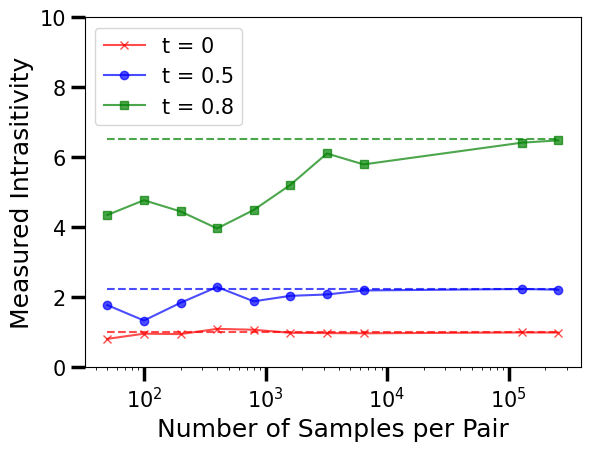

In [ ]:
# Now we plot how the measured intransitivity approaches the ground truth value
# this is for the rock paper scissors case.

download = 0

# sets up the figure
fig, ax = plt.subplots()
ax.set_ylim([0, 10])
plt.subplots_adjust(bottom=0.15)

# set the parameters for both axis: label size in font points, the line tick line
# width and length in pixels
ax.tick_params(axis='both', which='major', labelsize=15, width=2.5, length=10)

pmf_list = pmf_list_intransitive
# iterate over the number of pmfs

colours = ['red', 'blue', 'green']
markers = ['x', 'o', 's']
t = [0,0.5,0.8]
for i in range(len(pmf_list_intransitive)):
  pmf_choice = i

  # shannon entropy denoted by H
  H = shannon_entropy(pmf_list[pmf_choice][:,0])

  sample_size_list = np.array([50, 100, 200, 400,
                               800, 1600, 3200, 6400,
                               128000, 256000])
  values, bounds, matrices = empirical_measurements(pmf_list,
                                            pmf_choice,
                                            sample_sizes = sample_size_list)

  t_val = t[i]
  label = 't = {}'.format(t_val)
  ax.semilogx(sample_size_list,
              values, label = label,
              c = colours[i],
              alpha = 0.7,
              marker = markers[i])

  ax.semilogx([sample_size_list[0],
               sample_size_list[-1]],
              [ground_truth_measurements_intransitive[i],
               ground_truth_measurements_intransitive[i]],
              c = colours[i],
              linestyle='--',
              alpha = 0.7)

ax.legend(loc='upper left', fontsize = 15)
ax.set_xlabel('Number of Samples per Pair', fontsize =18)
ax.set_ylabel('Measured Intrasitivity', fontsize =18)


if download:
  plt.savefig("EloSimIntransitive.svg")
  plt.savefig("EloSimIntransitive.png")
  plt.savefig("EloSimIntransitive.pdf")

  files.download("EloSimIntransitive.png")
  files.download("EloSimIntransitive.svg")
  files.download("EloSimIntransitive.pdf")

/tmp/ipython-input-525601592.py:72: RuntimeWarning: divide by zero encountered in log
  H = np.dot(np.log(pmf), pmf)
/tmp/ipython-input-525601592.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  matrix[i,j] = vector[i] - vector[j]


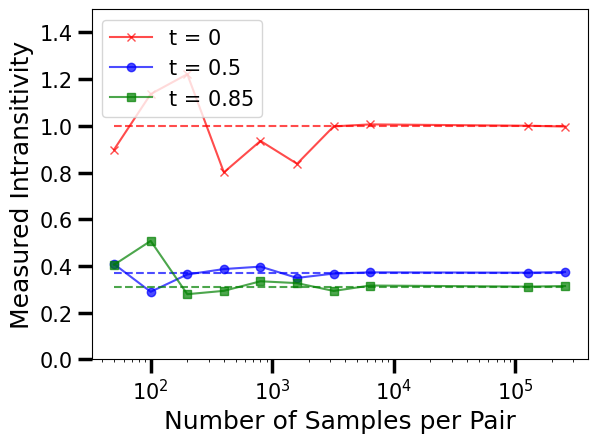

In [ ]:
# Now we plot how the measured intransitivity approaches the ground truth value
# this is for the rock scissors case.

download = 0

# sets up the figure
fig, ax = plt.subplots()
ax.set_ylim([0, 1.5])
plt.subplots_adjust(bottom=0.15)
# set the parameters for both axis: label size in font points, the line tick line
# width and length in pixels
ax.tick_params(axis='both', which='major', labelsize=15, width=2.5, length=10)

pmf_list = pmf_list_transitive

# iterate over the number of pmfs

colours = ['red', 'blue', 'green']
markers = ['x', 'o', 's']
t = [0,0.5,0.85]
for i in range(len(pmf_list_transitive)):
  pmf_choice = i

  # shannon entropy denoted by H
  H = shannon_entropy(pmf_list[pmf_choice][:,0])

  sample_size_list = np.array([50, 100, 200, 400,
                               800, 1600, 3200, 6400,
                               128000, 256000])
  values, bounds, matrices = empirical_measurements(pmf_list,
                                            pmf_choice,
                                            sample_sizes = sample_size_list)

  t_val = t[i]
  label = 't = {}'.format(t_val)
  ax.semilogx(sample_size_list,
              values, label = label,
              c = colours[i],
              alpha = 0.7,
              marker = markers[i])

  ax.semilogx([sample_size_list[0],
               sample_size_list[-1]],
              [ground_truth_measurements_transitive[i],
               ground_truth_measurements_transitive[i]],
              c = colours[i],
              linestyle='--',
              alpha = 0.7)

ax.legend(loc='upper left', fontsize = 15)
ax.set_xlabel('Number of Samples per Pair', fontsize =18)
ax.set_ylabel('Measured Intransitivity', fontsize =18)


if download:
  plt.savefig("EloSimTransitive.svg")
  plt.savefig("EloSimTransitive.png")
  plt.savefig("EloSimTransitive.pdf")

  files.download("EloSimTransitive.png")
  files.download("EloSimTransitive.svg")
  files.download("EloSimTransitive.pdf")

/tmp/ipython-input-525601592.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  matrix[i,j] = vector[i] - vector[j]


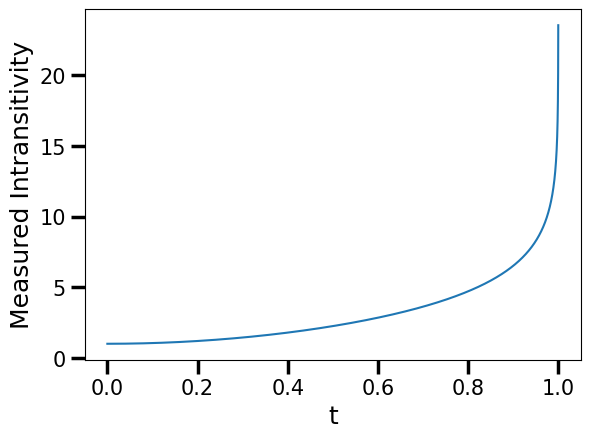

In [ ]:
def parametrised_intransitivity_rs(n):
  """
  Calculates the intransitivity of Rock-Scissors (no paper) in two players play
  Rock and Scissors respectively with increasing frequencies.
  """
  intransitivity_measurements = []
  p_list = []
  for i in range(n):
    p = 0.5 + (i+1)/(2*n+1)
    p_list.append(p)
    pmf = np.array([[p, 0.5, 1-p],[0,0,0],[1-p, 0.5, p]])
    intransitivity_measurements.append(intransitivity_measure(payoff_matrix(pmf, payoff_rps)))
  return p_list, intransitivity_measurements


def parametrised_intransitivity_rps(n):
  """
  Calculated the parametrised intransitivty for rock-paper-scissors. Where we
  interpolate between Nash equilibrium (all players play strategies with equal
  probability) and pur strategies in which one player plays only one strategy.
  """
  intransitivity_measurements = []
  p_list = []
  for i in range(n):
    p = (i+1)/(n+1)
    p_list.append(p)
    pmf = (1-p)*nash_matrix + p*pure_strategy_matrix
    intransitivity_measurements.append(intransitivity_measure(payoff_matrix(pmf, payoff_rps)))
  return p_list, intransitivity_measurements


# Now we plot how the measured intransitivity approaches the ground truth value
# this is for the intransititve case.

# plots the empirical
fig, ax = plt.subplots()
ax.tick_params(axis='both', which='major', labelsize=15, width=2.5, length=10)
plt.subplots_adjust(bottom=0.15)
pmf_list = pmf_list_transitive

a,b = parametrised_intransitivity_rps(10000)
plt.plot(a, b)

ax.set_xlabel('t', fontsize =18)
ax.set_ylabel('Measured Intransitivity', fontsize =18)

# variable to decide whether to download the figure.
download = False
if download:
  plt.savefig("intransitivitymeasurerps.svg")
  plt.savefig("intransitivitymeasurerps.png")
  plt.savefig("intransitivitymeasurerps.pdf")

  files.download("intransitivitymeasurerps.png")
  files.download("intransitivitymeasurerps.svg")
  files.download("intransitivitymeasurerps.pdf")


/tmp/ipython-input-525601592.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  matrix[i,j] = vector[i] - vector[j]


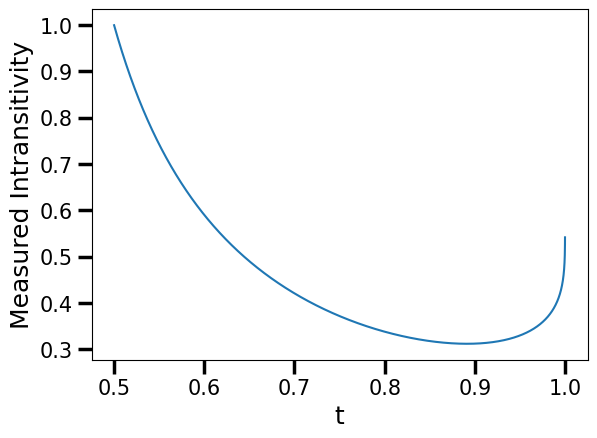

In [ ]:
# Now we plot how the measured intransitivity approaches the ground truth value
# this is for the intransititve case.




# plots the empirical
fig, ax = plt.subplots()
ax.tick_params(axis='both', which='major', labelsize=15, width=2.5, length=10)
plt.subplots_adjust(bottom=0.15)
pmf_list = pmf_list_transitive

a,b = parametrised_intransitivity_rs(10000)
plt.plot(a, b)

ax.set_xlabel('t', fontsize =18)
ax.set_ylabel('Measured Intransitivity', fontsize =18)

download = 0
if download:
  plt.savefig("transitivitymeasurers.svg")
  plt.savefig("transitivitymeasurers.png")
  plt.savefig("transitivitymeasurers.pdf")

  files.download("transitivitymeasurers.png")
  files.download("transitivitymeasurers.svg")
  files.download("transitivitymeasurers.pdf")

In [ ]:
# Elo simulation code
import copy as copy
"""
Here we will simulate the Elo ratings
there are three players in the popultion
- They will play rock, paper, or scissors with a different probability
- we will adjust the selection matrices Q, this
"""

def RPS_strategy_profile(t):
  """
  takes a parameter t and returns three PMFs for how likely three players
  would be to play rock, paper, or scissors


  inputs:
    t: float
      The parameter, where player i players with PMF
      (1 - t)(1/3, 1/3, 1/3) + t*np.eye(3)[i,:]

  outputs:
    P: np.array
      expected payoff matrix associated with the strategy profile. \
      where players play a
    PMFs: np.array
      array whose ith row is the PMF of player i playing rock paper
      and scissors respectively.
  """
  uniform_matrix = (1/3)*np.ones((3, 3))
  shift = np.array([[0,1,0],[0,0,1],[1,0,0]])
  print(np.array([1,2,3])@shift)
  P = np.zeros((3,3)) # preallocates the expected payoff matrix

  PMFs = (1 - t) * uniform_matrix + t* np.eye(3)

  # calculate the probability of victory
  # prob_victory = p_win/(1 - p_draw)
  for i in range(3):
    for j in range(i+1, 3):
      p_ij_win = np.dot(PMFs[i],(PMFs[j]@shift))

      p_ij_draw = np.dot(PMFs[i],PMFs[j])
      P[i, j] = p_ij_win/(1 - p_ij_draw)
      P[j, i] = 1 - p_ij_win/(1 - p_ij_draw)
  P += 0.5*np.eye(3) # prob i beats i is 0.5

  return P, PMFs

def unfold(Q):
  """
  unfolds a selection matrix Q into a dictionary
  This is used to provide inputs to the function sample_Q, which is used to
  sample pairs of players according to Q.
  """
  Q_dict = {}
  pair_dict = {}
  count = 0
  for i in range(len(Q)):
    for j in range(i+1, len(Q)):
      Q_dict[count] = Q[i,j]
      pair_dict[count] = (i,j)
      count += 1
  return Q_dict, pair_dict


def sample_Q(Q_dict, pair_dict):
  """
  samples pairs of players from Q after it has been passed through the unfold
  function
  """
  index = np.random.choice(range(len(Q)), size=1, p=list(Q_dict.values()))
  return pair_dict[index[0]]


def RPS_simulation(selection_matrix,
                   expected_payoff_matrix,
                   iterations = 1000,
                   eta = 0.1,
                   initial_ratings = np.zeros(3)):
  """
  simulates the Elo rating system

  outputs:
    r: a list of vectors each of which
  """
  Q_dict, pair_dict = unfold(selection_matrix)
  # iterates over the number of iterations.
  r_history = []
  P = expected_payoff_matrix
  r = initial_ratings
  for t in range(iterations):
    # sample two different players according to Q
    i,j = sample_Q(Q_dict, pair_dict)

    # obtain the outcome from P
    outcome_t = 1*(np.random.rand() < P[i,j])

    # iterate the Elo rating accordingly
    r[i] += eta*(outcome_t - expit(r[i] - r[j]))
    r[j] -= eta*(outcome_t - expit(r[i] - r[j]))

    r_history.append(copy.copy(r))
  return r_history


# testing the functions.
P, PMFs = RPS_strategy_profile(0.85)
Q = np.array([[0,0.1, 0.2],[0,0,0.7],[0,0,0]])
Q = np.array([[0,0.1, 0.8],[0,0,0.1],[0,0,0]])

Q_dict, pair_dict = unfold(Q)
r_hist = RPS_simulation(Q,
               P,
               iterations = 2000,
               eta = 0.01,
               initial_ratings = np.zeros(3))


[3 1 2]


[3 1 2]
Simulating Elo trajectories
final Elo ratings [-0.77463163  0.827489   -0.05878598]  2D coordinates (np.float64(0.0695774832400172), np.float64(-1.1328703660558355))
final Elo ratings [ 0.73304069 -0.00677162 -0.72908456]  2D coordinates (np.float64(0.8917931555072534), np.float64(0.5231263044258933))
Calculating vertices of Elotope
Elotope vertex cordinates: [-2.17597947e+00  1.54542285e-16  2.17597947e+00]
Elotope vertex cordinates: [ 1.54542285e-16  2.17597947e+00 -2.17597947e+00]
Elotope vertex cordinates: [ 2.17597947e+00 -2.17597947e+00 -3.37511599e-17]


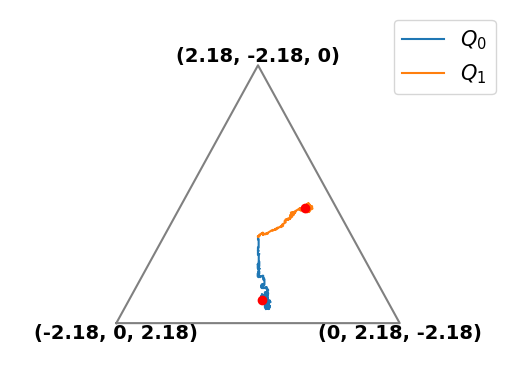

In [ ]:
# plotting the RPS simulations with different Q matrices
def proj_matrix(v_list):
  """
  Given a list of vectors v, return a matrix A such that Av returns v
  projected onto the space spanned by A
  """
  def proj(v,w):
    """
    projects v onto w
    """
    return np.dot(v,w)/np.linalg.norm(w)

  # applies gram schmidt to the vectors in v_list to obtain orthonormal basis
  orthonormal_vectors = []
  for v in v_list:
    for w in orthonormal_vectors:
      v = v - proj(v,w)*w
    v = v/np.linalg.norm(v)
    orthonormal_vectors.append(v)
  return np.array(orthonormal_vectors)

def vector_to_string(vec, zero_threshold=1e-7):
    def round_sig(x, sig=4):
        if abs(x) < zero_threshold:
            return '0'
        else:
            return f"{x:.{sig - int(np.floor(np.log10(abs(x)))) - 1}g}"

    rounded = [round_sig(x) for x in vec]
    return f"({', '.join(rounded)})"

def RPS_simulation_plot(Q_matrices,
                        expected_payoff_matrix,
                        iterations = 1000,
                        eta = 0.01,
                        initial_ratings = np.zeros(3),
                        download = 0):
  """
  inputs: a list of Q matrices
  an expected payoff matrix
  number of iterations
  eta: is the learning rate of the Elo update algorithm
  initial ratings: initial ratings of the three players
  download: set to 1 if you wish to download the figure.
  """

  fig, ax = plt.subplots()

  P = expected_payoff_matrix
  r_trajectories = []
  projection_matrix = proj_matrix([[1,1,-2],[1,-1,0]])
  projection_matrix = projection_matrix.T

  # iterates over the Q matrices
  for Q in Q_matrices:
    r_hist = RPS_simulation(Q,
                            P,
                            iterations = iterations,
                            eta = eta,
                            initial_ratings = np.zeros(3))
    r_trajectories.append(copy.deepcopy(r_hist))

  # takes the R_histories
  count = 0
  print("Simulating Elo trajectories")
  for r_hist in r_trajectories:
    r_array = np.array(r_hist)
    r_array = r_array@projection_matrix
    p0 = r_array[:,0]
    p1 = r_array[:,1]
    # plot the line of Elo rating trajectory
    plt.plot(p0,p1, label=f"$Q_{{{count}}}$")
    # plot circle of final Elo score
    plt.plot(p0[-1], p1[-1], 'o', color = 'red')
    print("final Elo ratings", r_hist[-1], " 2D coordinates", (p0[-1], p1[-1]))
    count += 1
  plt.legend(fontsize = 15)

  # plots the Elotope
  # Code for the RPS Elotope
  spanning_trees = [[(0,1),(1,2)],
                    [(0,2),(0,1)],
                    [(0,2),(1,2)]]
  vertices = [] # preallocates the vertices of the Elotope
  Elotope_coords = [] # coordiantes of Elotope vertices prior to projection
  print("Calculating vertices of Elotope")
  for tree in spanning_trees:
    A = np.zeros((3,3)) # matrix in system of linear equations
    b = np.zeros(3) # vector in system of linear equations.
    row = 0 # start working at row zero
    for pair in tree:
      i = pair[0]
      j = pair[1]
      A[row][i] = 1
      A[row][j] = -1
      b[row] = logit(P[i,j])
      row+=1
    A[row,:] = np.ones(3)
    print("Elotope vertex cordinates:", np.linalg.inv(A)@b)
    Elotope_coords.append(np.linalg.inv(A)@b)
    solution = np.linalg.inv(A)@b@projection_matrix
    vertices.append(solution)
  vertices.append(vertices[0])
  vertices = np.array(vertices).T
  plt.plot(vertices[0], vertices[1], color = 'gray')


  # changes the appearence of the figure

  # plots the coordinates of the vertices of the Elotope
  # stores the coordinate labels and their locations in two lists
  coord_string_list = []
  xy_coords_list = []
  for i in range(len(Elotope_coords)):
    string_coords = vector_to_string(Elotope_coords[i])
    # take the column since we took the transponse of the array earlier

    xy_coords = (vertices[0,i], vertices[1,i])
    coord_string_list.append(string_coords)
    xy_coords_list.append(xy_coords)
  #
  plt.annotate(coord_string_list[0], xy_coords_list[0],
               horizontalalignment='center',
               verticalalignment='top', fontsize=14, fontweight='bold')
  plt.annotate(coord_string_list[1], xy_coords_list[1],
               horizontalalignment='center',
               verticalalignment='top', fontsize=14, fontweight='bold')
  plt.annotate(coord_string_list[2], xy_coords_list[2],
               horizontalalignment='center',
               verticalalignment='bottom', fontsize=14, fontweight='bold')

  # removes ticks from the python plot
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  left=False, labelbottom=False, labelleft=False)


  # specify the limits of the figure
  xmin = min(vertices[0,:])
  xmax = max(vertices[0,:])
  plt.xlim(xmin-2, xmax + 2)

  ymin = min(vertices[1,:])
  ymax = max(vertices[1,:])
  plt.ylim(ymin-1, ymax + 1)

  # Remove the spines
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)

  if download:
    print('download is 1')
    plt.savefig("EloSimulations.svg")
    plt.savefig("EloSimulations.png")
    plt.savefig("EloSimulations.pdf")
    files.download("EloSimulations.png")
    files.download("EloSimulations.svg")
    files.download("EloSimulations.pdf")


# the expecte payoff matrix used in this

P, PMFs = RPS_strategy_profile(0.85)
Q_matrices = [np.array([[0,0.8, 0.1],[0,0,0.1],[0,0,0]]),
              np.array([[0,0.1, 0.8],[0,0,0.1],[0,0,0]])]

RPS_simulation_plot(Q_matrices,
                    P,
                    iterations = 1000,
                    eta = 0.02,
                    initial_ratings = np.zeros(3),
                    download = 0)